## 第五章 PyTorch 常用工具模块

在训练神经网络的过程中, 需要用到很多工具, 其中最重要的三部分是: 数据、可视化和 GPU 加速. 本章主要介绍 PyTorch 在这几方面的工具模块, 合理使用这些工具能够极大地提高我们的编程效率.

### 5.1 数据处理

在解决深度学习问题的过程中, 我们往往需要花费大量的精力去处理数据, 包括图像、文本、语音或其它二进制数据等. 数据的处理对训练神经网络来说十分重要, 良好的数据处理不仅会加速模型训练, 也会提高模型效果.
考虑到这点, PyTorch 提供了几个高效便捷的工具, 以便使用者进行数据处理或数据增强等操作, 同时可通过并行化加速数据的加载过程.

#### 5.1.1 Dataset

在 PyTorch 中, 数据加载可通过自定义的数据集对象实现. 数据集对象被抽象为 `Dataset` 类, 实现自定义的数据集需要继承 `Dataset`, 并实现两个 Python 魔法方法:

- `__getitem__()`: 返回一条数据, 或一个样本.
  `obj[index]` 等价于 `obj.__getitem__(index)`

- `__len__()`: 返回样本的数量
  `len(obj)` 等价于 `obj.__len__()`

这里我们以 Kaggle 经典挑战赛 "Dogs vs Cats" 的数据为例, 来详细讲解如何处理数据. "Dogs vs Cats" 是一个分类问题, 其目的为判断一张图片是狗还是猫. 在该问题中, 所有图片都存放在一个文件夹下, 并可以根据文件名的前缀得到它们的标签值(狗还是猫).

In [1]:
%env LS_COLORS = None
!tree --charset ascii  data/dogcat/

env: LS_COLORS=None
data/dogcat/
|-- cat.12484.jpg
|-- cat.12485.jpg
|-- cat.12486.jpg
|-- cat.12487.jpg
|-- dog.12496.jpg
|-- dog.12497.jpg
|-- dog.12498.jpg
`-- dog.12499.jpg

0 directories, 8 files


In [2]:
import torch as t
from torch.utils.data import Dataset

t.__version__

'2.4.1+cpu'

In [9]:
import os
from PIL import Image
import numpy as np


class DogCat(Dataset):
    def __init__(self, root):
        # print("root:", root)  # root: ./data/dogcat/

        imgs = os.listdir(root)
        # print("imgs:", imgs)  # imgs: ['cat.12484.jpg', 'cat.12485.jpg', 'cat.12486.jpg', 'cat.12487.jpg', 'dog.12496.jpg', 'dog.12497.jpg', 'dog.12498.jpg', 'dog.12499.jpg']
        
        # 所有图片的绝对路径
        # 这里不实际加载图片, 只是指定路径, 当调用 __getitem__ 时才会真正读图片
        self.imgs = [os.path.join(root, img) for img in imgs]
        # print("self.imgs:", self.imgs)
        # self.imgs: ['./data/dogcat/cat.12484.jpg', './data/dogcat/cat.12485.jpg', './data/dogcat/cat.12486.jpg', './data/dogcat/cat.12487.jpg', './data/dogcat/dog.12496.jpg', './data/dogcat/dog.12497.jpg', './data/dogcat/dog.12498.jpg', './data/dogcat/dog.12499.jpg']

    def __getitem__(self, index):
        # print("index:", index)  # index: 0

        img_path = self.imgs[index]
        # print("img_path:", img_path)  # img_path: ./data/dogcat/cat.12484.jpg

        # dog -> 1,  cat -> 0
        label = 1 if "dog" in img_path.split("/")[-1] else 0
        # print("label:", label)  # label: 0

        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label

    def __len__(self):
        return len(self.imgs)

In [10]:
import warnings

warnings.filterwarnings("ignore")

dataset = DogCat("./data/dogcat/")
img, label = dataset[0]  # 相当于调用 dataset.__getitem__(0)
for img, label in dataset:
    print(img.size(), img.float().mean(), label)

torch.Size([500, 497, 3]) tensor(106.4917) 0
torch.Size([499, 379, 3]) tensor(171.8088) 0
torch.Size([236, 289, 3]) tensor(130.3022) 0
torch.Size([374, 499, 3]) tensor(115.5157) 0
torch.Size([375, 499, 3]) tensor(116.8187) 1
torch.Size([375, 499, 3]) tensor(150.5086) 1
torch.Size([377, 499, 3]) tensor(151.7141) 1
torch.Size([400, 300, 3]) tensor(128.1548) 1


通过上面的代码, 我们学习了如何定义自己的数据集, 并对其进行遍历. 但这里返回的数据并不适合实际使用, 主要存在以下两方面问题:

- 返回样本的形状不一, 也就是每张图片的大小不一样, 这对于需要取 batch 训练的神经网络来说很不友好

- 返回样本的数值较大, 没有进行归一化.

针对上述问题, PyTorch 提供了 torchvision.torchvision 是一个视觉工具包, 提供了很多视觉图像处理的工具, 其中 `transforms` 模块提供了一系列数据增强的操作. 本章仅对其部分操作进行介绍, 完整内容可参考官方相关文档.

对 PIL Image 的部分操作包括:

- `Resize`: 调整图片尺寸

- `RandomAffine`: 对图像进行仿射变换

- `CenterCrop`、`RandomCrop`、`RandomResizedCrop`、`FiveCrop`: 对图像按不同规则进行裁剪

- `ColorJitter`: 修改图像的亮度、对比度以及饱和度

- `Pad`: 对图像进行填充

- `ToTensor`: 将 $H\times W\times C$ 维度的 PIL Image 对象转成维度为 $C\times H\times W$ 的 Tensor, 同时会自动将 \[0, 255] 归一化至 \[0, 1].

对 Tensor 的部分操作包括:

- `Normalize`: 标准化, 即减均值, 除以标准差

- `ToPILImage`: 将 Tensor 转为 PIL Image 对象

- `RandomErasing`: 随机擦除图像中矩形区域的部分像素.

对 Transforms 的操作包括:

- `RandomApply`: 对一个 transforms 按一定概率执行

- `RandomChoice`: 从一系列 transforms 随机执行一个操作

- `RandomOrder`: 对一系列 transforms 操作按随机顺序执行. 

如果要对图片进行多个操作, 可通过 `transforms.Compose` 将这些操作拼接起来, 类似于 `nn.Sequential`. 注意, 这些操作定义后是以对象形式存在的, 真正使用时需调用它的 `__call__` 方法, 这点类似于 `nn.Module`. 例如要将图片调整为 $224\times 224$, 首先应构建这个操作 `trans = Resize((224, 224))`, 然后调用 `trans(img)`. 下面我们就用 transforms 的这些操作来优化上面实现的 dataset.


In [11]:
import os
from PIL import Image
import numpy as np
from torchvision import transforms as T

transform = T.Compose(
    [
        T.Resize(224),  # 缩放图片(Image), 保持长宽比不变, 最短边为 224 像素
        T.CenterCrop(224),  # 从图片中间切出 224 * 224 的图片
        T.ToTensor(),  # 将图片(Image)转成 Tensor, 归一化至 [0, 1]
        T.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),  # 标准化至 [-1, 1], 规定均值和标准差
    ]
)


class DogCat(Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 0 if "dog" in img_path.split("/")[-1] else 1
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label

    def __len__(self):
        return len(self.imgs)


dataset = DogCat("./data/dogcat/", transforms=transform)
img, label = dataset[0]
for img, label in dataset:
    print(img.size(), label)

torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0


除了上述操作之外, transforms 还可通过 `Lambda` 封装自定义的转换策略. 例如想对 PIL Image 对象进行随机旋转, 就可以写成这样:
`trans=T.Lambda(lambda img: img.rotate(random() * 360))`.

同时, 与 `torch.nn` 以及 `torch.nn.functional` 类似, torchvision 也将 `transforms` 分解为 `torchvision.transforms` 以及 `torchvision.transforms.functional`. 相比于 `transforms` 而言, `transforms.functional` 为用户提供了更加灵活的操作, 读者在使用时需要自己指定所有的参数. 部分 `transforms.functional` 提供的操作如下, 完整内容可参考官方文档:

- `adjust_brightness`, `adjust_contrast`: 调整图像的亮度、对比度

- `crop`, `center_crop`, `five_crop`,`ten_crop`: 对图像按不同规则进行裁剪

- `normalize`: 标准化, 即减均值, 除以标准差

- `to_tensor`: 将 PIL Image 对象转成 Tensor.

由此可见 `transforms.functional` 中的操作与 `transforms` 是十分类似的, 相较于 transforms 而言, `transforms.functional` 可以对多个对象以相同的参数进行操作, 具体例子如下:

```python
import torchvision.transforms.functional as TF
import random
def transforms_rotate(image1, image2):
    angle=random.randint(0, 360)
    image1=TF.rotate(image1, angle)
    image2=TF.rotate(image2, angle)
    return image1, image2
```

除了对数据进行增强操作的 transforms 以外, torchvision 还预先实现了常用的 Dataset, 包括前面使用过的 CIFAR-10、ImageNet、COCO、MNIST 以及 LSUN 等数据集, 可通过诸如 `torchvision.datasets.CIFAR10` 来调用, 具体使用方法请参考官方文档.

在这里介绍一个会经常使用到的 Dataset —— `ImageFolder`, 它的实现和上述的 `DogCat` 很相似. `ImageFolder` 假设所有的文件按文件夹保存, 每个文件夹下存储同一个类别的图片, 文件夹名为类名, 其构造函数如下:

```
ImageFolder(root, transform=None, target_transform=None, loader=default_loader , is_valid_file=None)
```

其中:
- `root`: 在 root 指定的路径下寻找图片

- `transform`: 对 PIL Image 进行相关数据增强, transform 的输入是使用 loader 读取图片的返回对象

- `target_transform`: 对 label 的转换

- `loader`: 指定加载图片的函数, 默认操作是读取为 PIL Image 对象

- `is_valid_file`: 获取图像路径并检查文件的有效性

label 是按照文件夹名顺序排序后存成字典, 即{类名: 类序号(从 0 开始)}, 一般来说最好直接将文件夹命名为从 0 开始的数字, 这样会和 ImageFolder 实际的 label 一致, 如果不是这种命名规范, 建议通过 `self.class_to_idx` 属性了解 label 和文件夹名的映射关系.


In [12]:
!tree --charset ASCII  data/dogcat_2/

data/dogcat_2/
|-- cat
|   |-- cat.12484.jpg
|   |-- cat.12485.jpg
|   |-- cat.12486.jpg
|   `-- cat.12487.jpg
`-- dog
    |-- dog.12496.jpg
    |-- dog.12497.jpg
    |-- dog.12498.jpg
    `-- dog.12499.jpg

2 directories, 8 files


In [13]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder("data/dogcat_2/")
# cat 文件夹的图片对应 label 0, dog 对应 1
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [14]:
# 所有图片的路径和对应的 label
dataset.imgs

[('data/dogcat_2/cat/cat.12484.jpg', 0),
 ('data/dogcat_2/cat/cat.12485.jpg', 0),
 ('data/dogcat_2/cat/cat.12486.jpg', 0),
 ('data/dogcat_2/cat/cat.12487.jpg', 0),
 ('data/dogcat_2/dog/dog.12496.jpg', 1),
 ('data/dogcat_2/dog/dog.12497.jpg', 1),
 ('data/dogcat_2/dog/dog.12498.jpg', 1),
 ('data/dogcat_2/dog/dog.12499.jpg', 1)]

0


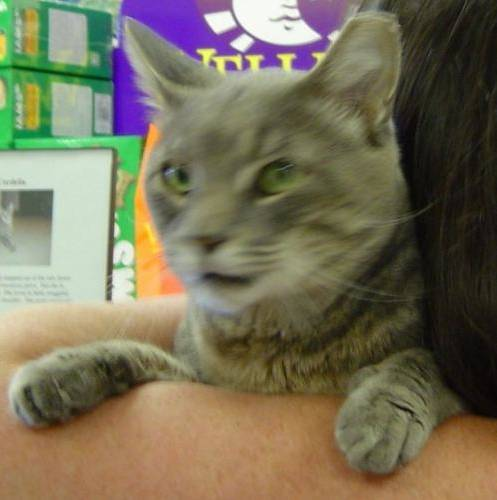

In [15]:
# 没有任何的 transform, 所以返回的还是 PIL Image 对象
print(dataset[0][1])  # 第一维是第几张图, 第二维为 1 返回 label
dataset[0][0]  # 为 0 返回图片数据

In [16]:
# 加上 transform
transform = T.Compose(
    [
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),  # 水平翻转
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [17]:
dataset = ImageFolder("data/dogcat_2/", transform=transform)
# 深度学习中图片数据一般保存成 C x H x W, 即通道数 x 图片高 x 图片宽
dataset[0][0].size()

torch.Size([3, 224, 224])

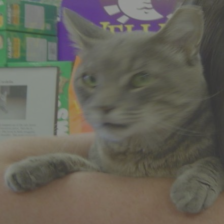

In [18]:
to_img = T.ToPILImage()
# 0.2 和 0.4 是标准差和均值的近似
to_img(dataset[0][0] * 0.2 + 0.4)

#### 5.1.2 DataLoader

`Dataset` 只负责数据的抽象, 一次调用 `__getitem__` 只返回一个样本. 前面提到过, 在训练神经网络时, 是对一个 batch 的数据进行操作的, 同时还需要对数据进行 shuffle 和并行加速等. 对此, PyTorch 提供了 `DataLoader` 帮助我们实现这些功能.

DataLoader 的函数定义如下:

```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=default_collate,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
    generator=None
)
```

其中:

- dataset: 加载的数据集(Dataset 对象)

- batch_size: 一个 batch 的大小

- shuffle: 是否将数据打乱

- sampler: 样本抽样, 后续会详细介绍

- batch_sampler: 与 sampler 类似, 一次返回一个 batch 的索引(该参数与 batch_size, shuffle, sampler, drop_last 不兼容)

- num_workers: 使用多进程加载的进程数, 0 代表不使用多进程

- collate_fn: 如何将多个样本数据拼接成一个 batch, 一般使用默认的拼接方式即可

- pin_memory: 是否将数据保存在 pin memory 区, pin memory 中的数据转到 GPU 会快一些

- drop_last: dataset 中的数据个数可能不是 batch_size 的整数倍, drop_last 为 True 会将多出来不足一个 batch 的数据丢弃

- timeout: 进程读取数据的最大时间, 若超时则丢弃数据

- worker_init_fn: 每个 worker 的初始化函数

In [19]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False
)
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.size()  # batch_size, channel, height, width

torch.Size([3, 3, 224, 224])

DataLoader 是一个可迭代(Iterable)的对象, 我们可以像使用迭代器一样使用它, 例如:

```python
for batch_datas, batch_labels in dataloader:
    train()
```

或

```python
dataiter = iter(dataloader)
batch_datas, batch_labesl = next(dataiter)
```

在数据处理中, 有时会出现某个样本无法读取等问题, 比如某张图片损坏. 这时在 `__getitem__` 函数中将出现异常, 最好的解决方案便是将出错的样本剔除. 如果实在是遇到这种情况无法处理, 则可以返回 None 对象, 然后在 Dataloader 中实现自定义的 `collate_fn`, 将空对象过滤掉. 但要注意, 在这种情况下 DataLoader 返回的一个 batch 的样本数目会少于 batch_size.

In [20]:
class NewDogCat(DogCat):  # 继承前面实现的 DogCat 数据集
    def __getitem__(self, index):
        try:
            # 调用父类的获取函数, 即 DogCat.__getitem__(self, index)
            return super().__getitem__(index)
        except:
            return None, None


from torch.utils.data.dataloader import default_collate  # 导入默认的拼接方式


def my_collate_fn(batch):
    """
    batch 是一个 list, 每个元素是 dataset 的返回值, 形如(data, label)
    """
    # 过滤为 None 的数据
    batch = [_ for _ in batch if _[0] is not None]
    if len(batch) == 0:
        return t.Tensor()
    return default_collate(batch)  # 用默认方式拼接过滤后的 batch 数据

In [21]:
dataset = NewDogCat("data/dogcat_wrong/", transforms=transform)
dataset[10]

(None, None)

In [22]:
dataloader = DataLoader(
    dataset, 2, collate_fn=my_collate_fn, num_workers=0, shuffle=True
)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(), batch_labels.size())

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])


来看一下上述 batch_size 的大小. 其中第 3 个的 batch_size 为 1, 这是因为有一张图片损坏, 导致其无法正常返回. 而最后 1 个的 batch_size 也为 1, 这是因为共有 9 张(包括损坏的文件)图片, 无法整除 2(batch_size), 因此最后一个 batch 的数据会少于 batch_size. 我们可以通过指定 `drop_last=True` 来丢弃最后一个不足 batch_size 的 batch.

对于样本损坏或数据集加载异常等情况, 还可以通过其它方式解决. 例如随机取一张图片代替出现异常的图片:

```python
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except:
            new_index = random.randint(0, len(self)-1)
            return self[new_index]
```

相比较丢弃异常图片而言, 这种做法会更好一些, 因为它能保证每个 batch 的数目仍是 batch_size. 但在大多数情况下, 最好的方式还是对数据进行彻底清洗.

DataLoader 里面并没有太多的魔法方法, 它封装了 Python 的标准库 `Multiprocessing`, 使其能够实现多进程加速. 下面将对 DataLoader 的多进程并行原理进行简要介绍.

DataLoader 默认使用单进程进行数据加载, 这样的加载方式较慢, 但在系统资源有限或数据集较小能够直接加载时是十分推荐的, 因为单进程的数据加载在 debug 时能够显示更多错误信息.

当数据量较大时, 用户可以通过 `num_workers` 参数进行多进程的数据读取, 其底层并行流程如下:

![DataLoader底层原理](imgs/DataLoader.png)

主进程首先启动, 并产生队列 `index_queue`, 其中包含每一个 worker 应该处理的数据下标. 每一个 worker 加载一个 batch 的数据, 并返回队列 `worker_result_queue`, 其中包含应该返回的数据下标.同时, 每一个 worker 重复执行 `_worker_loop` 循环以读取 `worker_result_queue`, 并将样本数据放入 `data_queue` 中, 最终便得到所有样本数据. 在 DataLoader 输出数据之前应该在队列 `index_queue` 中置入下一批的数据下标. 重复执行如上流程, DataLoader 便完成了多进程的数据读取, 更多细节可参考 DataLoader 的相关源码.

在 Dataset 和 DataLoader 的使用方面有几点建议:

1. 将高负载的操作放在 `__getitem__` 中, 如加载图片等
  
2. Dataset 中应尽量只包含只读对象, 避免修改任何可变对象.

第一点是因为多进程会并行的调用 `__getitem__` 函数, 将负载高的放在 `__getitem__` 函数中能够实现并行加速.

第二点是因为 DataLoader 使用多进程加载, 如果在 `Dataset` 中使用了可变对象, 可能会有意想不到的冲突. 在多线程/多进程中, 修改一个可变对象, 需要加锁, 但是 DataLoader 的设计使得加锁很困难(在实际使用中也应尽量避免锁的存在), 因此最好避免在 Dataset中 修改可变对象. 下面就是一个不好的例子, 在多进程处理中 `self.num` 可能与预期不符, 这种问题不会报错, 因此难以发现. 如果一定要修改可变对象, 建议使用 Python 标准库 `Queue` 中的相关数据结构.

```python
class BadDataset(Dataset):
    def __init__(self):
        self.datas = range(100)
        self.num = 0 # 取数据的次数

    def __getitem__(self, index):
        self.num += 1
        return self.datas[index]
```

使用 Python `Multiprocessing` 库的另一个问题是, 在使用多进程时, 如果主程序异常终止(比如用 Ctrl+C 强行退出), 相应的数据加载进程可能无法正常退出. 这时你可能会发现程序已经退出了, 但 GPU 显存和内存依旧被占用着, 同时通过 `top`、`ps aux` 依旧能够看到已经退出的程序, 这时就需要手动强行杀掉进程. 建议使用如下命令:

```
ps x | grep <cmdline> | awk '{print $1}' | xargs kill
```

- `ps x`: 获取当前用户的所有进程

- `grep <cmdline>`: 找到已经停止的 PyTorch 程序的进程, 例如你是通过 python train.py 启动的, 那你就需要写 `grep 'python train.py'`

- `awk '{print $1}'`: 获取进程的 pid

- `xargs kill`: 杀掉进程, 根据需要可能要写成 `xargs kill -9` 强制杀掉进程

在执行这句命令之前, 建议先打印确认进程

```
ps x | grep <cmdline> | ps x
```

PyTorch 中还单独提供了一个 `Sampler` 模块, 用来对数据进行采样. 常用的有随机采样器: `RandomSampler`, 当 DataLoader 的 `shuffle` 参数为 True 时, 系统会自动调用这个采样器, 实现打乱数据.默认的是采用 `SequentialSampler`, 它会按顺序一个一个进行采样. 这里介绍另外一个很有用的采样方法:
 `WeightedRandomSampler`, 它会根据每个样本的权重选取数据, 在样本比例不均衡的问题中, 可用它来进行重采样.

构建 `WeightedRandomSampler` 时需提供两个参数: 每个样本的权重 `weights`、选取的样本总数 `num_samples`, 以及一个可选参数 `replacement`. 权重越大的样本被选中的概率越大, 待选取的样本数目一般小于全部的样本数目. `replacement`用于指定是否可以重复选取某一个样本, 默认为 True, 即允许在一个 epoch 中重复采样某一个数据. 如果设为 False, 当某一类的样本被全部选取完, 但其样本数目仍未达到 num_samples 时, sampler 将不会再从该类中选择数据, 此时可能导致 `weights` 参数失效. 下面举例说明.

In [28]:
dataset = DogCat("data/dogcat/", transforms=transform)
# 假设狗的图片被取出的概率是猫的概率的两倍
# 两类图片被取出的概率与 weights 的绝对大小无关, 只和比值有关
weights = [2 if label == 1 else 1 for data, label in dataset]
weights

[2, 2, 2, 2, 1, 1, 1, 1]

In [29]:
from torch.utils.data.sampler import WeightedRandomSampler

sampler = WeightedRandomSampler(weights, num_samples=9, replacement=True)
dataloader = DataLoader(dataset, batch_size=3, sampler=sampler)
for datas, labels in dataloader:
    print(labels.tolist())

[1, 1, 1]
[1, 1, 0]
[1, 1, 1]


可见猫狗样本比例约为 1:2, 另外一共只有 8 个样本, 但是却返回了 9 个, 说明有样本被重复返回的, 这就是 replacement 参数的作用, 下面将 replacement 设为 False 试试.

In [30]:
sampler = WeightedRandomSampler(weights, 8, replacement=False)
dataloader = DataLoader(dataset, batch_size=4, sampler=sampler)
for datas, labels in dataloader:
    print(labels.tolist())

[1, 1, 0, 1]
[0, 1, 0, 0]


在这种情况下, num_samples 等于 dataset 的样本总数, 为了不重复选取, sampler 会将每个样本都返回, 这样就失去 weight 参数的意义了.

从上面的例子可见 sampler 在样本采样中的作用: 如果指定了 sampler, shuffle 将不再生效, 并且 sampler.num_samples 会覆盖 dataset 的实际大小, 即一个 epoch 返回的图片总数取决于 `sampler.num_samples`.

本节主要介绍了数据加载常见的两个操作: Dataset 与 DataLoader, 并结合实际数据对其魔法方法与底层原理进行了简要的介绍. 由于数据准备与加载是神经网络中最基本的环节之一, 读者应熟悉其常见操作, 并可根据个人实际需要对其进行进一步的了解.

### 5.2 计算机视觉工具包: torchvision

计算机视觉是深度学习中最重要的一类应用, 为了方便研究者使用, PyTorch 团队专门开发了一个视觉工具包 `torchvision`, 这个包独立于 PyTorch, 需通过 `pip install torchvision` 安装. 在之前的例子中我们已经使用过它的部分功能, 这里再做一个系统性的介绍. torchvision 主要包含三部分:

- datasets: 提供常用的数据集加载, 设计上都是继承 `torch.utils.data.Dataset`, 主要包括 `MNIST`、`CIFAR10/100`、`ImageNet`、`COCO` 等

- models: 提供深度学习中各种经典网络的网络结构以及预训练好的模型, 包括经典的分类模型如 `VGG`、`ResNet`、`MobileNet` 等, 目标检测模型如 `Faster RCNN`、`Mask RCNN`, 语义分割模型等

- transforms: 提供常用的数据预处理操作, 主要包括对 Tensor、PIL Image 对象以及 Transforms 的操作.

接下来我们将使用 torchvision 中的 Mask RCNN 来进行一次简单的实例分割:

In [ ]:
from torchvision import models
from torchvision import transforms as T
from torch import nn
from PIL import Image
import numpy as np
import random
import cv2

# 加载预训练好的模型, 如果不存在会自动下载
# 预训练好的模型保存在 ~/.torch/models/下面
detection = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
detection.eval()


def predict(img_path, threhold):
    # 数据预处理, 标准化至 [-1, 1], 规定均值和标准差
    img = Image.open(img_path)
    transform = T.Compose(
        [T.ToTensor(), T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
    )
    img = transform(img)
    # 对图像进行预测
    pred = detection([img])
    # 对预测结果进行后处理: 得到 mask 与 bbox
    score = list(pred[0]["scores"].detach().numpy())
    t = [score.index(x) for x in score if x > threhold][-1]
    mask = (pred[0]["masks"] > 0.5).squeeze().detach().cpu().numpy()
    pred_boxes = [
        [(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]["boxes"].detach().numpy())
    ]
    pred_masks = mask[: t + 1]
    boxes = pred_boxes[: t + 1]
    return pred_masks, boxes

Transforms 中涵盖了大部分对 Tensor 和 PIL Image 的常用处理, 这些已在上文提到, 这里就不再详细介绍. 需要注意的是转换分为两步, 第一步: 构建转换操作, 例如 `transf = transforms.Normalize(mean=x, std=y)`, 第二步: 执行转换操作, 例如`output = transf(input)`. 另外还可将多个处理操作用 Compose 拼接起来, 构成一个处理转换流程.

In [ ]:
# 随机颜色, 以便可视化
def color(image):
    colours = [[0, 255, 255], [0, 0, 255], [255, 0, 0]]
    R = np.zeros_like(image).astype(np.uint8)
    G = np.zeros_like(image).astype(np.uint8)
    B = np.zeros_like(image).astype(np.uint8)
    R[image == 1], G[image == 1], B[image == 1] = colours[random.randrange(0, 3)]
    color_mask = np.stack([R, G, B], axis=2)
    return color_mask

In [ ]:
# 对 mask 与 bounding box 进行可视化
def result(img_path, threhold=0.7, rect_th=1, text_size=1, text_th=2):
    masks, boxes = predict(img_path, threhold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        color_mask = color(masks[i])
        img = cv2.addWeighted(img, 1, color_mask, 0.5, 0)
        cv2.rectangle(
            img, boxes[i][0], boxes[i][1], color=(255, 0, 0), thickness=rect_th
        )
    return img

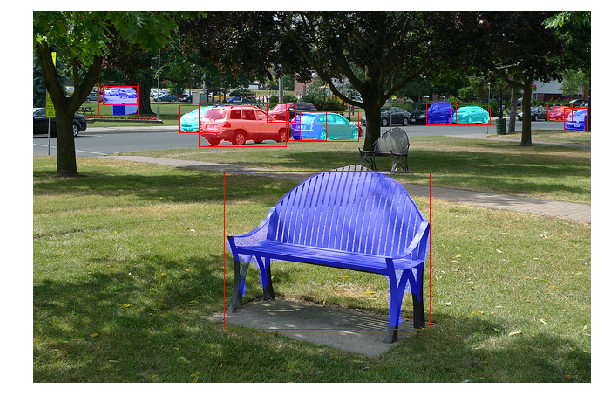

In [ ]:
from matplotlib import pyplot as plt

img = result("data/demo.jpg")
plt.figure(figsize=(10, 10))
plt.axis("off")
img_result = plt.imshow(img)

至此我们便完成了一个简单的实例分割任务. 如上图所示, Mask RCNN 能够分割出该图像中的部分实例, 读者可考虑对预训练模型进行 finetune 以适应不同场景以及不同任务. 请注意, 上述代码的计算均在 CPU 上进行, 速度较慢, 若条件支持可考虑在 GPU 上进行计算加速, 具体操作可参考本章第四节.

### 5.3 可视化工具

在训练神经网络时, 我们希望能更直观地了解训练情况, 包括损失曲线、输入图片、输出图片、卷积核的参数分布等信息. 这些信息能帮助我们更好地监督网络的训练过程, 并为参数优化提供方向和依据. 最简单的办法就是打印输出, 但其只能打印数值信息, 不够直观, 同时无法查看分布、图片、声音等. 在本节, 我们将介绍两个深度学习中常用的可视化工具: Tensorboard 和 Visdom.

#### 5.3.1 TensorBoard

TensorBoard 最初是作为 TensorFlow 的可视化工具迅速流行开来. 作为和 TensorFlow 深度集成的工具, TensorBoard 能够展现 TensorFlow 网络计算图, 绘制图像生成的定量指标图以及附加数据. 同时 TensorBoard 也是一个相对独立的工具, 只要用户保存的数据遵循相应的格式, TensorBoard 就能读取这些数据并进行可视化.

在 PyTorch 1.14 版本以后, PyTorch 内部已经内置了 TensorBoard 相关接口, 用户在手动安装 TensorBoard 后便可调用相关接口开始数据的可视化.

![TensorBoard界面](imgs/Tensorboard_main.png)

TensorBoard 的使用非常简单. 首先用如下命令安装 TensorBoard:

```bash
pip install tensorboard
```

后续可通过如下命令启动 TensorBoard, 其中 path 为 log 文件的保存路径:

```bash
tensorboard --logdir=path
```

Tensorboard 的常见操作包括记录标量、显示图像、显示直方图、显示网络结构、可视化 embedding 等, 下面将逐一举例说明:

In [31]:
import torch
import numpy as np
import torchvision
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 构建 logger 对象, logdir 用来指定 log 文件的保存路径
logger = SummaryWriter("runs")

ModuleNotFoundError: No module named 'tensorboard'

In [ ]:
# 使用add_scalar记录标量
for n_iter in range(100):
    logger.add_scalar("Loss/train", np.random.random(), n_iter)
    logger.add_scalar("Loss/test", np.random.random(), n_iter)
    logger.add_scalar("Acc/train", np.random.random(), n_iter)
    logger.add_scalar("Acc/test", np.random.random(), n_iter)

![add_scalar效果示意](imgs/Tensorboard_scalar.png)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = datasets.MNIST("data/", download=True, train=False, transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
images, labels = next(iter(dataloader))
grid = torchvision.utils.make_grid(images)

In [ ]:
# 使用add_image显示图像
logger.add_image("images", grid, 0)

![add_image效果示意](imgs/Tensorboard_img.png)

In [ ]:
# 使用add_graph可视化网络
class ToyModel(nn.Module):
    def __init__(self, input_size=28, hidden_size=500, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = ToyModel()
logger.add_graph(model, images)

![add_graph效果示意](imgs/Tensorboard_net.png)

In [ ]:
# 使用add_histogram显示直方图
logger.add_histogram("normal", np.random.normal(0, 5, 1000), global_step=1)
logger.add_histogram("normal", np.random.normal(1, 2, 1000), global_step=10)

![add_histogram效果示意(1)](imgs/Tensorboard_His.png)
![add_histogram效果示意(2)](imgs/Tensorboard_Distribution.png)

In [ ]:
# 使用add_embedding进行embedding可视化
dataset = datasets.MNIST("data/", download=True, train=False)
images = dataset.data[:100].float()
label = dataset.targets[:100]
features = images.view(100, 784)
logger.add_embedding(features, metadata=label, label_img=images.unsqueeze(1))

![add_embedding效果示意](imgs/Tensorboard_embedding.png)

打开浏览器输入`http://localhost:6006`(其中6006应改成读者tensorboard所绑定的端口), 便可看到上述可视化结果.

Tensorboard十分容易上手, 读者可以根据个人需求灵活使用上述函数在训练网络时进行可视化, 从而更加容易发现可能的问题所在.需要注意的是, 上文仅介绍了Tensorboard的部分常见操作, 详细内容可参考官方相关源码.


#### 5.3.2 Visdom
Visdom是Facebook专门为PyTorch开发的一款可视化工具, 开源于2017年3月.Visdom十分轻量级, 但却支持非常丰富的功能, 能胜任大多数的科学运算可视化任务.其可视化界面如下图所示.

![visdom界面](imgs/visdom_main.png)


Visdom可以创造、组织和共享多种数据的可视化, 包括数值、图像、文本, 甚至是视频, 支持PyTorch、Torch及Numpy.用户可通过编程组织可视化空间, 或通过用户接口为生动数据打造仪表板, 检查实验结果或调试代码.

Visdom中有两个重要概念:
- env: 环境.不同环境的可视化结果相互隔离, 互不影响, 在使用时如果不指定env, 默认使用`main`.不同用户、不同程序一般使用不同的env；
- pane: 窗格.窗格可用于可视化图像、数值或打印文本等, 其可以拖动、缩放、保存和关闭.一个程序可使用同一个env中的不同pane, 每个pane可视化或记录某一信息.

Visdom的安装可通过命令`pip install visdom`.安装完成后, 需通过`python -m visdom.server`命令启动visdom服务, 或通过`nohup python -m visdom.server &`命令将服务放至后台运行.Visdom服务是一个web server服务, 默认绑定8097端口, 客户端与服务器间通过tornado进行非阻塞交互.

Visdom的使用有两点需要注意的地方:
- 需手动指定保存env, 可在web界面点击save按钮或在程序中调用save方法, 否则visdom服务重启后, env等信息会丢失；
- 客户端与服务器之间的交互采用tornado异步框架, 可视化操作不会阻塞当前程序, 网络异常也不会导致程序退出.

Visdom以Plotly为基础, 支持丰富的可视化操作, 下面举例说明一些最常用的操作.

In [ ]:
%%sh
# 启动visdom服务器
# nohup python -m visdom.server &

In [ ]:
import torch as t
import visdom

# 新建一个连接客户端
# 指定env = u'test1', 默认端口为8097, host是‘localhost'
vis = visdom.Visdom(env="test1", use_incoming_socket=False)

x = t.arange(0, 30, 0.01)
y = t.sin(x)
vis.line(X=x, Y=y, win="sinx", opts={"title": "y=sin(x)"})

Setting up a new session...
Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


'sinx'

输出的结果如下图所示.
![visdom的输出](imgs/visdom_sinx.png)

下面逐一分析这几行代码:
- vis = visdom.Visdom(env=u'test1'), 用于构建一个客户端, 客户端除指定env之外, 还可以指定host、port等参数；
- vis作为一个客户端对象, 可以使用常见的画图函数, 包括:

    - line: 类似Matlab中的`plot`操作, 用于记录某些标量的变化, 如损失、准确率等；
    - image: 可视化图片, 可以是输入的图片, 也可以是GAN生成的图片, 还可以是卷积核的信息；
    - text: 用于记录日志等文字信息, 支持html格式；
    - histgram: 可视化分布, 主要是查看数据、参数的分布；
    - scatter: 绘制散点图；
    - bar: 绘制柱状图；
    - pie: 绘制饼状图；
    - 更多操作可参考visdom的github主页.
    
这里主要介绍深度学习中常见的line、image和text操作.

Visdom同时支持PyTorch的Tensor和NumPy的ndarray两种数据结构, 但不支持Python的int、float等类型, 因此每次传入时都需先将数据转成ndarray或Tensor.上述操作的参数一般不同, 但有两个参数是绝大多数操作都具备的:
- win: 用于指定pane的名字, 如果不指定, visdom将自动分配一个新的pane.如果两次操作指定的win名字一样, 新的操作将覆盖当前pane的内容, 因此建议每次操作都重新指定win；
- opts: 选项, 接收一个字典, 常见的option包括`title`、`xlabel`、`ylabel`、`width`等, 主要用于设置pane的显示格式.

之前提到过, 每次操作都会覆盖之前的数值, 但往往我们在训练网络的过程中需不断更新数值, 如损失值等, 这时就需要指定参数`update='append'`来避免覆盖之前的数值.而除了使用update参数以外, 还可以使用`vis.updateTrace`方法来更新图, `updateTrace`不仅能在指定pane上新增一个和已有数据相互独立的Trace, 还能像`update='append'`那样在同一条trace上追加数据.

In [ ]:
# append 追加数据
for ii in range(0, 10):
    # y = x
    x = t.Tensor([ii])
    y = x
    vis.line(X=x, Y=y, win="polynomial", update="append" if ii > 0 else None)

# updateTrace 新增一条线
x = t.arange(0, 9, 0.1)
y = (x**2) / 9
vis.line(X=x, Y=y, win="polynomial", name="this is a new Trace", update="new")

'polynomial'

打开浏览器, 输入`http://localhost:8097`, 可以看到如下图所示的结果.
![append和updateTrace可视化效果 ](imgs/visdom_update.svg)

image的画图功能可分为如下两类:
- `image`接收一个二维或三维向量, $H\times W$或$3 \times H\times W$, 前者是黑白图像, 后者是彩色图像；
- `images`接收一个四维向量$N\times C\times H\times W$, $C$可以是1或3, 分别代表黑白和彩色图像.可实现类似torchvision中make_grid的功能, 将多张图片拼接在一起.`images`也可以接收一个二维或三维的向量, 此时它所实现的功能与image一致.

In [ ]:
# 可视化一个随机的黑白图片
vis.image(t.randn(64, 64).numpy())

# 可视化一张随机的彩色图片
vis.image(t.randn(3, 64, 64).numpy(), win="random2")

# 可视化36张随机的彩色图片, 每一行6张
vis.images(
    t.randn(36, 3, 64, 64).numpy(), nrow=6, win="random3", opts={"title": "random_imgs"}
)

'random3'

其中images的可视化输出如下图所示.
![images可视化输出](imgs/visdom_images.png)

`vis.text`用于可视化文本, 支持所有的html标签, 同时也遵循着html的语法标准.例如, 换行需使用`<br>`标签, `\r\n`无法实现换行.下面举例说明.

In [ ]:
vis.text(
    """<h1>Hello Visdom</h1><br>Visdom是Facebook专门为<b>PyTorch</b>开发的一个可视化工具,
         在内部使用了很久, 在2017年3月份开源了它.

         Visdom十分轻量级, 但是却有十分强大的功能, 支持几乎所有的科学运算可视化任务""",
    win="visdom",
    opts={"title": "visdom简介"},
)

'visdom'

![text的可视化输出](imgs/visdom_text.png)

本节主要介绍了深度学习中两种常见的可视化工具:Tensorboard与Visdom, 并对其常见操作进行了简单介绍.合理利用可视化工具将方便我们记录与观察神经网络的中间层与训练效果, 从而帮助我们更好的对网络进行调整.在本书第九至十四章中均会使用这两种工具进行实际案例的可视化, 读者可在后续章节中留意.

### 5.4 使用GPU加速: cuda
这部分内容在前面介绍Tensor、Module时已经有所涉及, 这里将做一个总结, 并深入介绍相关应用.

在PyTorch中以下数据结构分为CPU和GPU两个版本:
- Tensor；
- nn.Module(包括常用的layer、loss function, 以及容器Sequential等).

它们都带有一个`.cuda`方法, 调用此方法即可将其转为对应的GPU对象.注意, `tensor.cuda`会返回一个新对象, 这个新对象的数据已转移至GPU, 而之前的tensor还在原来的设备上(CPU).而`module.cuda`则会将所有的数据都迁移至GPU, 并返回自己.所以`module = module.cuda()`和`module.cuda()`效果一致.

nn.Module在GPU与CPU之间的转换, 本质上还是利用了Tensor在GPU和CPU之间的转换.`nn.Module`的cuda方法是将nn.Module下的所有parameter(包括子module的parameter)都转移至GPU, 而Parameter本质上也是tensor(Tensor的子类).

下面将举例说明, 这部分代码需要你具有两块GPU设备.

注意: 为什么将数据转移至GPU的方法叫做`.cuda`而不是`.gpu`, 就像将数据转移至CPU调用的方法是`.cpu`？这是因为GPU的编程接口采用CUDA, 而目前并不是所有的GPU都支持CUDA, 只有部分NVIDIA的GPU才支持.PyTorch未来可能会支持AMD的GPU, 而AMD GPU的编程接口采用OpenCL, 因此PyTorch还预留着`.cl`方法, 用于以后支持AMD等的GPU.

In [ ]:
tensor = t.Tensor(3, 4)
# 返回一个新的tensor, 保存在第1块GPU上, 但原来的tensor并没有改变
tensor.cuda(0)
tensor.is_cuda  # False

False

In [ ]:
# 不指定所使用的GPU设备, 将默认使用第1块GPU
tensor = tensor.cuda()
tensor.is_cuda  # True

True

In [ ]:
module = nn.Linear(3, 4)
module.cuda(device=1)
module.weight.is_cuda  # True

True

In [ ]:
class VeryBigModule(nn.Module):
    def __init__(self):
        super(VeryBigModule, self).__init__()
        self.GiantParameter1 = t.nn.Parameter(t.randn(100000, 20000)).cuda(0)
        self.GiantParameter2 = t.nn.Parameter(t.randn(20000, 100000)).cuda(1)

    def forward(self, x):
        x = self.GiantParameter1.mm(x.cuda(0))
        x = self.GiantParameter2.mm(x.cuda(1))
        return x

上面最后一部分中, 两个Parameter所占用的内存空间都非常大, 大概是8个G, 如果将这两个都同时放在一块GPU上几乎会将显存占满, 无法再进行任何其它运算.此时可通过这种方式将不同的计算分布到不同的GPU中.

关于使用GPU的一些建议:
- GPU运算很快, 但对于很小的运算量来说, 并不能体现出它的优势, 因此对于一些简单的操作可直接利用CPU完成；
- 数据在CPU和GPU之间的传递会比较耗时, 应当尽量避免；
- 在进行低精度的计算时, 可以考虑`HalfTensor`, 相比于`FloatTensor`能节省一半的显存, 但需千万注意数值溢出的情况.

这里需要专门提一下, 大部分的损失函数也都属于`nn.Module`, 但在使用GPU时, 很多时候我们都忘记使用它的`.cuda`方法, 这在大多数情况下不会报错, 因为损失函数本身没有可学习的参数(learnable parameters).但在某些情况下会出现问题, 为了保险起见同时也为了代码更规范, 应记得调用`criterion.cuda`.下面举例说明.

In [ ]:
# 交叉熵损失函数, 带权重
criterion = t.nn.CrossEntropyLoss(weight=t.Tensor([1, 3]))
input = t.randn(4, 2).cuda()
target = t.Tensor([1, 0, 0, 1]).long().cuda()

# 下面这行会报错, 因weight未被转移至GPU
# loss = criterion(input, target)

# 这行则不会报错
criterion.cuda()
loss = criterion(input, target)

criterion._buffers

OrderedDict([('weight', tensor([1., 3.], device='cuda:0'))])

而除了调用对象的`.cuda`方法之外, 还可以使用`torch.cuda.device`, 来指定默认使用哪一块GPU, 或使用`torch.set_default_tensor_type`使程序默认使用GPU, 不需要手动调用cuda.

In [ ]:
# 如果未指定使用哪块GPU, 默认使用GPU 0
x = t.cuda.FloatTensor(2, 3)
# x.get_device() == 0
y = t.FloatTensor(2, 3).cuda()
# y.get_device() == 0

# 指定默认使用GPU 1
with t.cuda.device(1):
    # 在GPU 1上构建tensor
    a = t.cuda.FloatTensor(2, 3)

    # 将tensor转移至GPU 1
    b = t.FloatTensor(2, 3).cuda()
    assert a.get_device() == b.get_device() == 1

    c = a + b
    assert c.get_device() == 1

    z = x + y
    assert z.get_device() == 0

    # 手动指定使用GPU 0
    d = t.randn(2, 3).cuda(0)
    assert d.get_device() == 0

In [ ]:
t.set_default_tensor_type(
    "torch.cuda.FloatTensor"
)  # 指定默认tensor的类型为GPU上的FloatTensor
a = t.ones(2, 3)
a.is_cuda

True

如果服务器具有多个GPU, `tensor.cuda()`方法会将tensor保存到第一块GPU上, 等价于`tensor.cuda(0)`.此时如果想使用第二块GPU, 需手动指定`tensor.cuda(1)`, 而这需要修改大量代码, 很是繁琐.这里有两种替代方法:

- 一种是先调用`t.cuda.set_device(1)`指定使用第二块GPU, 后续的`.cuda()`都无需更改, 切换GPU只需修改这一行代码；
- 第二种方法是设置环境变量`CUDA_VISIBLE_DEVICES`, 例如当`export CUDA_VISIBLE_DEVICE=1`(下标是从0开始, 1代表第二块GPU), 只使用第二块物理GPU, 但在程序中这块GPU会被看成是第一块逻辑GPU, 因此此时调用`tensor.cuda()`会将Tensor转移至第二块物理GPU.`CUDA_VISIBLE_DEVICES`还可以指定多个GPU, 如`export CUDA_VISIBLE_DEVICES=0,2,3`, 那么第一、三、四块物理GPU会被映射成第一、二、三块逻辑GPU, `tensor.cuda(1)`会将Tensor转移到第三块物理GPU上.

设置`CUDA_VISIBLE_DEVICES`有两种方法, 一种是在命令行中`CUDA_VISIBLE_DEVICES=0,1 python main.py`, 一种是在程序中`import os;os.environ["CUDA_VISIBLE_DEVICES"] = "2"`.如果使用IPython或者Jupyter notebook, 还可以使用`%env CUDA_VISIBLE_DEVICES=1,2`来设置环境变量.

同时, 基于PyTorch本身的机制, 读者可能需要自己编写设备兼容(Device-agnostic)的代码, 以适应不同的计算环境.在第三章中已经介绍到, 我们可以通过Tensor的`device`属性指定其加载的设备, 同时利用`to`方法我们可以很方便的将不同变量加载到不同的设备上.下面将展示如何编写设备兼容的代码.  

首先介绍一下如何指定Tensor分配的设备, 这一操作往往是通过`torch.device()`命令实现的, 其中的device类型包含`cpu`与`cuda`两种类型.

In [ ]:
# 指定设备,使用CPU
t.device("cpu")
# 另外一种写法: t.device('cpu',0)

device(type='cpu')

In [ ]:
# 指定设备, 使用第一块GPU
t.device("cuda:0")
# 另外一种写法: t.device('cuda',0)

device(type='cuda', index=0)

In [ ]:
# 更加推荐的做法(同时也是设备兼容的): 如果用户具有GPU设备则使用GPU, 否则使用CPU
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# 在确定了设备之后, 我们便可以将数据与模型利用`to`方法加载到指定的设备上了.
x = t.empty((2, 3), device=device)

同时, 对于最常见的Tensor, 其封装好的大部分操作也支持其指定加载的设备.而当读者已经拥有加载在一个设备上的Tensor时, 通过torch.Tensor.new_* 以及torch.ones_like等操作我们也可以创建与该Tensor相同类型相同设备的Tensor, 具体操作如下:

In [ ]:
x_cpu = t.empty(2, device="cpu")
print(x_cpu, x_cpu.is_cuda)
x_gpu = t.empty(2, device=device)
print(x_gpu, x_gpu.is_cuda)

tensor([0., 0.], device='cpu') False
tensor([0.0000, 1.8750]) True


In [ ]:
# 使用new_*操作会保留原Tensor的包括设备的其他属性
y_cpu = x_cpu.new_full((3, 4), 3.1415)
print(y_cpu, y_cpu.is_cuda)
y_gpu = x_gpu.new_zeros(3, 4)
print(y_gpu, y_gpu.is_cuda)

tensor([[3.1415, 3.1415, 3.1415, 3.1415],
        [3.1415, 3.1415, 3.1415, 3.1415],
        [3.1415, 3.1415, 3.1415, 3.1415]], device='cpu') False
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) True


In [ ]:
# 使用ones_like或zeros_like可以创建与原Tensor大小类别均相同的new Tensor
z_cpu = t.ones_like(x_cpu)
print(z_cpu, z_cpu.is_cuda)
z_gpu = t.zeros_like(x_gpu)
print(z_gpu, z_gpu.is_cuda)

tensor([1., 1.], device='cpu') False
tensor([0., 0.]) True


在一些实际应用场景下代码的可移植性是十分重要的, 读者可根据上述内容继续深入学习, 并在不同实际场景中灵活运用PyTorch的不同特性编写代码, 以适应不同环境的工程需要.  
本节主要介绍了如何使用GPU对计算进行加速, 同时介绍了如何编写设备兼容的PyTorch代码.然而, 在实际应用场景中, 仅仅使用CPU或一块GPU是很难满足网络的训练需求的, 因此是否能够使用多块GPU来加速训练呢？  
答案是肯定的.自PyTorch 0.2版本后, PyTorch新增分布式GPU支持.分布式是指有多个GPU在多台服务器上, 而并行一般指的是一台服务器上的多个GPU.分布式涉及到了服务器之间的通信, 因此比较复杂, PyTorch封装了相应的接口, 可以用几句简单的代码实现分布式训练.在训练数据集较大或者网络模型较为复杂时, 合理地利用分布式与并行能够加快网络的训练速度, 从而更好验证不同的算法, 关于分布式与并行的更多内容将在本书第七章进行详细的介绍.

### 本章小结
本章介绍了一些工具模块, 这些工具有的已封装在PyTorch之中, 有的是独立于PyTorch的第三方模块.这些模块主要涉及数据加载、可视化与GPU加速的相关内容, 合理使用这些模块可以极大地提升我们的编程效率.